In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import csv
import pandas as pd
import jenkspy
from scipy.stats.distributions import chi2

# Creating a HMM from scratch

## Creating a hidden Markov model
To create a hidden Markov model (HMM), we require some parameters $\theta$. This comprises: the set of hidden states, $S$, the set of emission variables, $V$, the transition matrix, $\bf{A}$, the initial distribution, $\mu^{0}$ and the emission matrix, $\bf{B}$.

This code assumes the minimum value in $S$ is $0$ and the minimum value in $V$ is $1$, with both sets comprising integer values. For $J$ hidden states and $N$ emitted states, the matrices $\bf{A}$ and $\bf{B}$ have dimensions $JXJ$ and $JXN$ respectively. The initial distribution has dimensions $1XJ$.

This program reads these parameters from a .csv file named, 'model_params', with the data required for each parameter on a single line.

In [2]:
# Reading in model parameters
with open('model_params.csv', 'r') as file:
    csv_reader = csv.reader(file)
    lines = list(csv_reader)
    hidden_states = np.array(lines[0], dtype=int)
    emission_states = np.array(lines[1], dtype=int)
    transition_matrix = np.array(lines[2], dtype=float).reshape((len(hidden_states), (len(hidden_states))))
    initial_distribution = np.array(lines[3], dtype=float)
    emission_matrix = np.array(lines[4], dtype=float).reshape((len(hidden_states), len(emission_states)))

In [3]:
class HiddenMarkovModel:
    def __init__(self, hidden_states, emission_states):
        self.states = hidden_states
        self.observations = emission_states
        self.num_states = len(hidden_states)
        self.num_observations = len(emission_states)
        self.transition_matrix = np.zeros((self.num_states, self.num_states))
        self.emission_matrix = np.zeros((self.num_states, self.num_observations))
        self.initial_distribution = np.zeros(self.num_states)

    def set_transition_matrix(self, transition_matrix):
        self.transition_matrix = transition_matrix

    def set_emission_matrix(self, emission_matrix):
        self.emission_matrix = emission_matrix

    def set_initial_distribution(self, initial_distribution):
        self.initial_distribution = initial_distribution

    def generate_sequence(self, sequence_length):
        # Generate a sequence of observations using the HMM
        sequence = []
        hidden_states = []
        current_state = np.random.choice(self.num_states, p=self.initial_distribution)
        for _ in range(sequence_length):
            hidden_states.append(current_state)
            # Emit an observation based on the current state
            # This assumes the total set of possible observations are given to the HMM
            observation = np.random.choice(self.observations, p=self.emission_matrix[current_state])
            # If the total set of possible observations is not given to the HMM, then use self.num_observations instead
            # Add one as np.random.choice will create a range from 0-(self.num_observations-1) to choose from
            # And our emission space starts from 1 and goes to self.num_observations
            sequence.append(observation)

            # Transition to the next state based on the transition matrix
            current_state = np.random.choice(self.num_states, p=self.transition_matrix[current_state])

        return sequence, hidden_states

    def forward_algorithm(self, observed_sequence):
        # Implements the scaled forward algorithm
        # Observed sequence starts from 1 but if we want to get the corresponding index from the emission matrix, then 
        # we need to take one off this value
        observed_sequence = observed_sequence - 1

        # The total number of time steps will be the same as the length of the observed sequence
        N = len(observed_sequence)
        # This matrix will compute the probability of a hidden state given the observed state for each time step
        alpha = np.zeros((N, self.num_states))
        # There is one scale factor for each time step
        scale_factors = np.zeros(N)

        # Initialisation
        alpha[0] = self.initial_distribution * self.emission_matrix[:, observed_sequence[0]]
        scale_factors[0] = 1.0 / np.sum(alpha[0])

        # Scaling alpha
        alpha[0] *= scale_factors[0]

        # Start the for loop at 1, as we have done the initialisation step now
        for n in np.arange(1, N):
            column_vector_for_observable = self.emission_matrix[:, observed_sequence[n]]

            alpha_t_minus_1 = alpha[n - 1]
            matrix_multiplication_result = alpha_t_minus_1 * self.transition_matrix.T
            matrix_multiplication_sum = matrix_multiplication_result.sum(axis=1)

            # This is set as an unscaled alpha, which will be overwritten by the scaled version
            alpha[n] = matrix_multiplication_sum * column_vector_for_observable
            scale_factors[n] = 1.0 / np.sum(alpha[n])

            # Scaling alpha
            alpha[n] *= scale_factors[n]

        log_scale_factors = np.log((1 / scale_factors))
        log_likelihood = np.sum(log_scale_factors)

        return log_likelihood, alpha, scale_factors

    def backward_algorithm(self, scale_factor_array, observed_sequence):
        # Initialise
        N = len(observed_sequence)
        beta_list = np.zeros((N, self.num_states))

        # We will be working backwards and the for loop below starts from 1, so we will need to flip some of the arrays
        scale_factor_array = np.flip(scale_factor_array)
        # The scale factor array passed in here is actually the reciprocal, multiply don't divide
        beta_list[0] = scale_factor_array[0]
        # Substract 1, as for the forward algorithm, as the observed variables range between 1 and 5 and we want to use 
        # them for indexing (indexing in Python starts from 0)
        observed_sequence = np.flip(observed_sequence) - 1

        for i in range(1, N):
            observed_variable = observed_sequence[i - 1]
            column_of_emission_matrix = self.emission_matrix[:, observed_variable]

            beta_n_plus_1 = beta_list[i - 1]

            new_beta_unscaled = (beta_n_plus_1 * column_of_emission_matrix * self.transition_matrix).sum(axis=1)

            beta_list[i] = new_beta_unscaled * scale_factor_array[i]
        # Flip the list so the start represents the beta for the first observation, not the last
        return np.flip(beta_list, axis=0)

    def compute_updated_transition_matrix(self, alphas, betas, observed_sequence_emission_matrix):
        updated_transition_matrix = np.zeros(self.transition_matrix.shape)
        # We will work in columns, picking a column of the matrix and updating all of the rows in that column at once
        for j in range(self.transition_matrix.shape[1]):
            # The summation only ranges up to the last value of alpha and from the 1st elements of the 
            # observed_sequence_emission_matrix and of beta (counting from 0)
            # The observed_sequence_emission_matrix only starts from the 1st observed variable though
            expectation_value_for_column_of_updated_matrix = (
                    alphas[:-1, ] * self.transition_matrix[:, j] * observed_sequence_emission_matrix[j][
                np.newaxis].T * np.tile(betas[1:, j], (2, 1)).T
            ).sum(axis=0)

            # Update the transition matrix not having normalised its values yet
            updated_transition_matrix[:, j] = expectation_value_for_column_of_updated_matrix

        # We need these values to normalise the new matrix - the function will return them as well as the updated
        # transition matrix so that the they can be used when updating the emission matrix
        rowsums_of_updated_transition_matrix = updated_transition_matrix.sum(axis=1)[np.newaxis].T

        #normalised_updated_transition_matrix = np.divide(updated_transition_matrix, rowsums_of_updated_transition_matrix, out=np.zeros_like(updated_transition_matrix), where=~np.isclose(rowsums_of_updated_transition_matrix,np.zeros_like(rowsums_of_updated_transition_matrix)))#updated_transition_matrix / rowsums_of_updated_transition_matrix
        normalised_updated_transition_matrix = np.divide(updated_transition_matrix,
                                                         rowsums_of_updated_transition_matrix)
        return normalised_updated_transition_matrix, rowsums_of_updated_transition_matrix

    def compute_updated_emission_matrix(self, alphas, betas, observed_sequence_emission_matrix,
                                        observed_seq_for_indexing,
                                        rowsums_for_transition_update):
        shape_of_emission_matrix = self.emission_matrix.shape
        updated_emission_matrix = np.zeros(shape_of_emission_matrix)

        for k in range(shape_of_emission_matrix[1]):
            # Multiply by 1 so the indicator vector turns numeric and take off the last element as it is not used in the summation
            indicator_vector = ((observed_seq_for_indexing == k) * 1)[:-1]

            for i in range(shape_of_emission_matrix[0]):
                # The summation over n does not include the final value for alpha, and only starts from the first value of beta 
                # and first column of observed_sequence_emission_matrix
                # The observed_sequence_emission_matrix only starts from the 1st observed variable already though
                indicator_multiplied_by_zeta_sum = (indicator_vector * alphas[:, i][:-1] * self.transition_matrix[i][
                    np.newaxis].T * observed_sequence_emission_matrix * betas[1:].T).sum(axis=1)

                # To sum over j's, sum again
                numerator = sum(indicator_multiplied_by_zeta_sum)
                # Update the corresponding emission matrix element with the unnormalised sum
                updated_emission_matrix[i][k] = numerator

        #normalised_updated_emission_matrix = np.divide(updated_emission_matrix, rowsums_for_transition_update, out=np.zeros_like(updated_emission_matrix), where=~np.isclose(rowsums_for_transition_update,np.zeros_like(rowsums_for_transition_update)))#updated_emission_matrix / rowsums_for_transition_update
        normalised_updated_emission_matrix = np.divide(updated_emission_matrix, rowsums_for_transition_update)
        return normalised_updated_emission_matrix

    def compute_updated_initial_distribution(self, alphas, betas, observed_seq_for_indexing):
        # Check this works for 1d array
        updated_initial_distribution = np.zeros(self.initial_distribution.shape)
        initial_alpha = alphas[0]
        # This stays fixed
        initial_beta = betas[1]

        for i in range(self.transition_matrix.shape[1]):
            alpha = initial_alpha[i]

            row_of_transition_matrix = self.transition_matrix[i]
            column_of_emission_matrix = self.emission_matrix[:, observed_seq_for_indexing[1]]

            updated_initial_distribution[i] = sum(
                alpha * row_of_transition_matrix * column_of_emission_matrix * initial_beta)

        return updated_initial_distribution

    def baum_welch(self, observed_sequence, threshold):
        # Set the initial delta so the while loop starts
        delta = threshold * 2
        likelihood_history = []

        iteration_counter = 0
        # This is passed in to the functions which update the HMM's parameters, the forward algorithm and backward algorithm subtract 1 already,
        # as they may be called outside an internal function and in this case, the user will want to pass in an emitted sequence as-is (starting
        # from 1)
        observed_sequence_for_indexing = observed_sequence - 1
        while delta > threshold:
            # Run the forward-backward algorithm
            fwd_data = self.forward_algorithm(observed_sequence)
            likelihood = fwd_data[0]
            alphas = fwd_data[1]
            scale_factors = fwd_data[2]

            betas = self.backward_algorithm(scale_factors, observed_sequence)
            # If this is the first iteration, there is no likelihood history yet
            if iteration_counter == 0:
                delta = delta
            else:
                delta = abs(likelihood - likelihood_history[iteration_counter - 1])

            # Find updated parameters and update HMM
            # Create a matrix to use in function to compute updated parameters which is based on the emission matrix and the 
            # observed sequence, starting from the first emission, as these algorithms require
            observed_sequence_emission_matrix = self.emission_matrix.T[observed_sequence_for_indexing[1:]].T
            new_initial_distribution = self.compute_updated_initial_distribution(alphas, betas,
                                                                                 observed_sequence_for_indexing)
            computing_updated_transition_matrix_results = self.compute_updated_transition_matrix(alphas, betas,
                                                                                                 observed_sequence_emission_matrix)
            new_transition_matrix = computing_updated_transition_matrix_results[0]
            new_transition_matrix_rowsums = computing_updated_transition_matrix_results[1]
            new_emission_matrix = self.compute_updated_emission_matrix(alphas, betas, observed_sequence_emission_matrix,
                                                                       observed_sequence_for_indexing,
                                                                       new_transition_matrix_rowsums)

            self.set_initial_distribution(new_initial_distribution)
            self.set_transition_matrix(new_transition_matrix)
            self.set_emission_matrix(new_emission_matrix)

            likelihood_history.append(likelihood)

            iteration_counter += 1

        return likelihood_history

    def baum_welch_multiple_sequences(self, observed_sequences, threshold):
        # Set the initial delta so the while loop starts
        delta = threshold * 2
        likelihood_history = []

        iteration_counter = 0
        # This is passed in to the functions which update the HMM's parameters, the forward algorithm and backward algorithm 
        # subtract 1 already, as they may be called outside an internal function and in this case, the user will want to 
        # pass in an emitted sequence as-is (starting from 1)
        observed_sequences_for_indexing = observed_sequences - 1
        while delta > threshold:
            transition_matrix_numerators = np.zeros(self.transition_matrix.shape)
            transition_matrix_rowsums = np.zeros((self.transition_matrix.shape[0], 1))

            emission_matrix_numerators = np.zeros(self.emission_matrix.shape)

            initial_distribution_numerators = np.zeros(self.initial_distribution.shape)
            likelihood_sum = 0
            # So that the sequences can be size independent and the likelihoods can be compared
            total_obs_across_all_sequences = len(observed_sequences.flatten())
            for observed_sequence_for_indexing in observed_sequences_for_indexing:
                # Run the forward-backward algorithm
                fwd_data = self.forward_algorithm(observed_sequence_for_indexing + 1)
                likelihood = fwd_data[0]
                alphas = fwd_data[1]
                scale_factors = fwd_data[2]

                likelihood_sum += likelihood
                average_likelihood = likelihood_sum / total_obs_across_all_sequences

                betas = self.backward_algorithm(scale_factors, observed_sequence_for_indexing + 1)
                # If this is the first iteration, there is no likelihood history yet
                if iteration_counter == 0:
                    delta = delta
                else:
                    delta = abs(average_likelihood - likelihood_history[iteration_counter - 1])

                # Find updated parameters and update HMM
                # Create a matrix to use in function to compute updated parameters which is based on the emission matrix and the 
                # observed sequence, starting from the first emission, as these algorithms require
                observed_sequence_emission_matrix = self.emission_matrix.T[observed_sequence_for_indexing[1:]].T
                new_initial_distribution = self.compute_updated_initial_distribution(alphas, betas,
                                                                                     observed_sequence_for_indexing)
                computing_updated_transition_matrix_results = self.compute_updated_transition_matrix(alphas, betas,
                                                                                                     observed_sequence_emission_matrix)
                new_transition_matrix = computing_updated_transition_matrix_results[0]
                new_transition_matrix_rowsums = computing_updated_transition_matrix_results[1]

                new_emission_matrix = self.compute_updated_emission_matrix(alphas, betas,
                                                                           observed_sequence_emission_matrix,
                                                                           observed_sequence_for_indexing,
                                                                           new_transition_matrix_rowsums)

                # We can get the numerators and denominators back for the transition and emission matrices, using the
                # rowsums from the transition matrix update
                transition_matrix_numerator = new_transition_matrix * new_transition_matrix_rowsums
                emission_matrix_numerator = new_emission_matrix * new_transition_matrix_rowsums

                # Now, add these values to the cumulative sum over all observed sequences
                transition_matrix_numerators += transition_matrix_numerator
                emission_matrix_numerators += emission_matrix_numerator
                initial_distribution_numerators += new_initial_distribution

                transition_matrix_rowsums += new_transition_matrix_rowsums
                likelihood_history.append(average_likelihood)

            self.set_initial_distribution(np.divide(initial_distribution_numerators, observed_sequences.shape[0]))
            self.set_transition_matrix(np.divide(transition_matrix_numerators, transition_matrix_rowsums))
            self.set_emission_matrix(np.divide(emission_matrix_numerators, transition_matrix_rowsums))

            iteration_counter += 1

        return likelihood_history

    def viterbi(self, observed_sequence):
        # Subtract 1, as observed variables range from 1-5, and Python works from 0 indexing
        observed_sequence_for_indexing = observed_sequence - 1
        N = len(observed_sequence_for_indexing)
        # Initialisation
        phi = np.zeros((N, len(self.initial_distribution)))
        # Problem if one of these values is 0, so set to minus infinity in this case
        for initial_prob_index in range(len(self.initial_distribution)):
            if self.initial_distribution[initial_prob_index] == 0.0:
                phi[0, initial_prob_index] = -float('inf')
            else:
                phi[0, initial_prob_index] = np.log(self.initial_distribution[initial_prob_index]) + np.log(
                    self.emission_matrix[initial_prob_index, observed_sequence_for_indexing[0]])

        psi = np.zeros((N, len(self.initial_distribution)))

        # Recursion
        for n in range(1, N):
            # A matrix, with each column representing the possible maximum values for the hidden state at the nth step
            matrix_to_find_maxima_in = (np.log(self.transition_matrix.T) + phi[n - 1]).T

            # Find the value of the maximum element in each column
            maximum_values = np.amax(matrix_to_find_maxima_in, axis=0)
            # Find the indices corresponding to those maximum values in each column
            max_indicies = np.argmax(matrix_to_find_maxima_in, axis=0)

            phi[n] = maximum_values + np.log(self.emission_matrix[:, observed_sequence_for_indexing[n]])
            psi[n] = max_indicies

        # Now traceback
        path_sequence = [np.argmax(phi[-1, :])]

        for i in range(N - 1, 0, -1):
            path_sequence.insert(0, int(psi[i][path_sequence[0]]))

        return path_sequence

## Generating hidden and emitted sequences
Since an emitted variable is dependent on the hidden state, to generate a sequence of emitted variables, we must have a sequence of hidden states.

A choice is made for the initial hidden state, with the respective probabilities of each hidden state's choosing being contained in $\mu^{0}$. Now the hidden state for the $0^{th}$ time step is known, an emission variable can be chosen based on probabilities contained in $\bf{B}$, for the given hidden state. For the next time step, another hidden state is chosen, using the probabilities contained in $\bf{A}$. An emission variable is then chosen in the same way.

This process repeats for the desired number of time steps to generate a hidden and emitted sequence.

For an example HMM, with $$\bf{B} =
\begin{bmatrix}
    0.4 & 0.3 & 0.2 & 0.1 & 0.0 \\
    0.0 & 0.1 & 0.2 & 0.3  & 0.4 \\
\end{bmatrix}
$$

and $$\bf{A} =
\begin{bmatrix}
    0.8 & 0.2 \\
    0.1 & 0.9 \\
\end{bmatrix}
$$

we should expect to see longer continuous sequences of a given hidden state than alternating sequences of hidden states. We should also expect to see hidden state, $0$ being more strongly associated with the emitted variables $1$ and $2$, and hidden state $1$ being more strongly associated with the emitted variables $4$ and $5$. There should be a roughly even association between the hidden states for the emitted variable $3$. This is reflected in the plots below.

The other parameters for this example HMM, which will be referred to throughout this document are: $\mu^{0} = \begin{bmatrix} 
    0.5 & 0.5 \\ 
    \end{bmatrix}$
, $V = \{1, 2, 3, 4, 5\}$ and $S = \{0, 1\}$.

In [4]:
hmm = HiddenMarkovModel(hidden_states, emission_states)

hmm.set_transition_matrix(transition_matrix)
hmm.set_emission_matrix(emission_matrix)
hmm.set_initial_distribution(initial_distribution)

# Generate a sequence of observations
generated_sequences = hmm.generate_sequence(115)
generated_emitted_states = np.array(generated_sequences[0])
generated_hidden_states = np.array(generated_sequences[1])

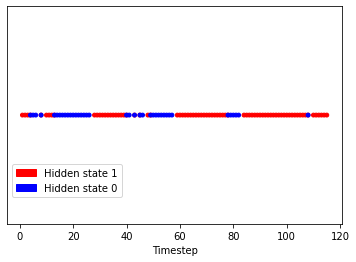

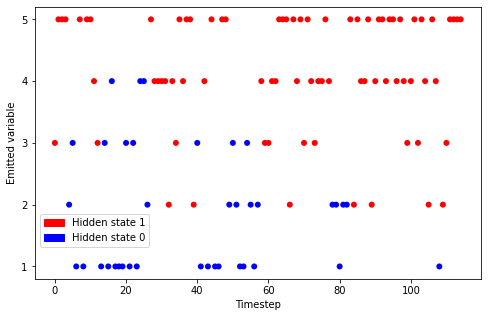

In [5]:
# Choose the colour of the points based on the hidden state
col = np.where(generated_hidden_states == 0, 'b', 'r')
red_patch = mpatches.Patch(color='red', label='Hidden state 1')
blue_patch = mpatches.Patch(color='blue', label='Hidden state 0')

# A plot to show the sequence of hidden states
plt.scatter(generated_hidden_states + range(len(generated_hidden_states)), np.full(len(generated_hidden_states), 1),
            np.full(len(generated_hidden_states), 15), c=col)
plt.rcParams['figure.figsize'] = [8, 5]
plt.xlabel("Timestep")
plt.yticks([])
plt.legend(handles=[red_patch, blue_patch], loc="lower left", bbox_to_anchor=(0, 0.1))
plt.show()

# A plot to show the dependance of emitted variable on the hidden state
plt.scatter(np.arange(len(generated_hidden_states)), generated_emitted_states, c=col, linewidth=0)
plt.yticks(np.arange(min(generated_emitted_states), max(generated_emitted_states) + 1, 1.0))
plt.legend(handles=[red_patch, blue_patch], loc="lower left", bbox_to_anchor=(0, 0.1))
plt.xlabel("Timestep")
plt.ylabel("Emitted variable")
plt.show()

In [6]:
# Reset figure size to default for later cells
plt.rcParams['figure.figsize'] = (6.0, 4.0)

## HMM parameter inference
Given some observed sequence, if we know the hidden states and the emission variable space, we are able to calculate the remaining parameters in $\theta$, using maximum likelihood inference. This is achieved using the Baum-Welch algorithm.

Once we have the full set of $\theta$, we are also able to calculate the most likely sequence of hidden states during the observed sequence using the Viterbi algorithm.

### The forward algorithm
The forward algorithm allows us to calculate the likelihood of a given observed sequence, given the full set of $\theta$. This algorithm involves defining a forward variable for each time step, $\alpha_{n}$. Forward variables are calculated recursively and then summed to find the likelihood $L$.

Since $\alpha_{0}$ is a value less than one and each recursive step involves multiplying the previous value of $\alpha$ by probability values from $\bf{A}$ and $\bf{B}$, the algorithm can lead to underflow for longer sequences.

Therefore, this program makes use of the scaled forward algorithm, which calculates the log-likelihood, $\ln{L}$, and defines a scaled forward variable for each time step, and each hidden variable, $i$, $\hat{\alpha}_{n}(i)$. Each $\hat{\alpha}_{n}(i)$ is still recursively calculated, but divided by a scale factor, $c_{n}$, which is a value less than one. The value of $\ln{L}$ is then given by the sum over all $\ln{c_{n}}$.

This program reads in an observed sequence from a .csv file, 'observed_sequence', which contains a generated emitted sequence. This read in sequence is then passed to the function, 'forward_algorithm' to run it.

Using the example HMM, and using the generated sequence from above, we can run the forward algorithm.

Once normalised for the sequence length, $\ln{L}$ is a value not far from $0$, indicating a good fit for the model. Furthermore, since each value of $\hat{\alpha}_{n}(i)$ is effectively normalised, then the sum of all $\hat{\alpha}_{n}$ across all hidden states should be approximately 1. This is a check to make sure the algorithm is working as intended.

In [38]:
# Write the emitted sequences to a .csv file, and then read it in
generated_emitted_states_as_int = generated_emitted_states.astype(int)
np.savetxt("observed_sequence.csv", generated_emitted_states, delimiter=",")

with open('observed_sequence.csv', 'r') as file:
    csv_reader = csv.reader(file)
    lines = list(csv_reader)
    read_in_observed_sequence = np.array(lines, dtype=float).flatten()

read_in_observed_sequence = read_in_observed_sequence.astype(int)

generated_observation_forward_algorithm_results = hmm.forward_algorithm(read_in_observed_sequence)
likelihood_of_generated_observations = generated_observation_forward_algorithm_results[0]

print("Normalised log-likelihood:",
      format(likelihood_of_generated_observations / len(read_in_observed_sequence), ".2f"))
alphas_for_generated_observations = generated_observation_forward_algorithm_results[1]

print("Sum of scaled forward variables across all hidden states: ")
print(alphas_for_generated_observations.sum(axis=1))

Normalised log-likelihood: -1.54
Sum of scaled forward variables across all hidden states: 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


#### The forward algorithm with real data
To test the forward algorithm on real data, the nucleotide sequence of Chromosome 3 of $\textit{Saccharomyces cerevisiae}$ (yeast) was downloaded from Ensembl.

The nucleotide sequence was then split into disjoint $100bp$ windows, with the start of each window separated by $40bp$. The GC content of each window was then calculated, to create a sequence of GC content values. These were then binned, to represent one of the $5$ emission variables.

The likelihood of the observed sequence is then calculated using the forward algorithm.

One binning scheme involved fitting the GC content to the distribution of emitted variables in a generated sequence (from the HMM described above), so that the proportion of each emitted variable was the same in the fitted GC content, as the generated sequence. Lower values of GC content were assigned a lower number in the emission space.

The other binning scheme involved Jenks natural breaks with 4 classes. The classes were assigned ascending integer values based on their centroid, with lower valued centroids being assigned to a lower integer number. Each element of the GC content was then altered to take the assigned integer value of the cluster it belonged to.

Each altered sequence is then passed into the forward algorithm, with the example HMM.

In both binning schemes, the sequence of emitted variables may not be representative of example HMM. However, the altered sequence in the first binning scheme at least has the correct proportions of emitted variables. This is not necessarily true of the altered sequence from the Jenks binning scheme. Therefore $\ln{L}$ of the first binning scheme should be higher than that for the second binning scheme - this is shown in the results. The likelihoods are not normalised, as they are calculated for the same length sequence.

The decision was made to use the Jenks binning scheme, as it creates the required number of classes for the emission space, whilst taking into account the structure of the GC content data.

In [8]:
file_path = "BK006937.2.fasta"

with open(file_path, "r") as file:
    lines = [line.strip() for line in file.readlines()[1:]]

# Concatenate lines into a single string
chromosome_content = ''.join(lines)

In [9]:
DEFINED_WINDOW_SHIFT_SIZE = 40
DEFINED_WINDOW_SIZE = 100


def find_gc_ratio(subsequence):
    g_count = float(subsequence.count('G'))
    c_count = float(subsequence.count('C'))

    gc_count = g_count + c_count

    return gc_count / float(len(subsequence))


def calculate_gc_content(sequence, window_shifts=DEFINED_WINDOW_SHIFT_SIZE):
    start = 0
    end = DEFINED_WINDOW_SIZE
    gc_contents = []

    while True:
        if end >= len(sequence):
            end = len(sequence)
            seq_window = sequence[start:end]
            gc_contents.append(find_gc_ratio(seq_window))
            break

        seq_window = sequence[start:end]
        gc_contents.append(find_gc_ratio(seq_window))

        start += window_shifts
        end += window_shifts

    return np.array(gc_contents)


chromosome_gc_content = calculate_gc_content(chromosome_content)

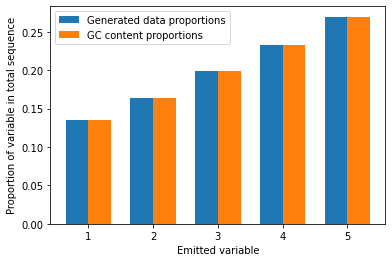

In [10]:
# Find the proportions of each observed variable in the emitted sequence
obs_seq_with_hidden_states = hmm.generate_sequence(len(chromosome_gc_content))
obs_seq = obs_seq_with_hidden_states[0]
emitted_variables, emitted_variables_count = np.unique(obs_seq, return_counts=True)

# We now want to make the gc_content data proportions resemble those of the emitted sequence
# Now, create a pandas data frame, which which we will sort by gc content
gc_content_df = pd.DataFrame(data=chromosome_gc_content,
                             index=np.arange(len(chromosome_gc_content)),
                             columns=["gc_content"])

# This is sorted in descending order
gc_content_df = gc_content_df.sort_values('gc_content')

# Now, alter the gc content values to a variable in the emission space
section_start = 0
for i in range(len(emitted_variables)):
    section_end = section_start + emitted_variables_count[i]
    gc_content_df.loc[gc_content_df.index[section_start:section_end], 'gc_content'] = emitted_variables[i]

    section_start = section_end

gc_content_df = gc_content_df.sort_index()

gc_content_fitted_first_binning_scheme = gc_content_df['gc_content'].to_numpy()

generated_seq_data_porportions_dict = dict(zip(emitted_variables, emitted_variables_count))
generated_data_proportions = []
for i in range(1, 6):
    generated_data_proportions.append(generated_seq_data_porportions_dict[i] / (sum(emitted_variables_count)))

gc_content_proportions = np.array(
    [np.count_nonzero(gc_content_fitted_first_binning_scheme == i) / len(gc_content_fitted_first_binning_scheme)
     for i in range(1, (max(emitted_variables) + 1))])

# Investigate whether the data proportions match

# Create a figure and axis
fig, ax = plt.subplots()

# Set the width of the bars
bar_width = 0.35

# Create bar positions for side-by-side bars
bar_positions1 = np.arange(len(generated_data_proportions))
bar_positions2 = bar_positions1 + bar_width

# Plot the side-by-side bars
ax.bar(bar_positions1, generated_data_proportions, width=bar_width, label='Generated data proportions')
ax.bar(bar_positions2, gc_content_proportions, width=bar_width, label='GC content proportions')

# Add labels and legend
ax.set_xlabel('Emitted variable')
ax.set_ylabel('Proportion of variable in total sequence')
ax.set_xticks(bar_positions1 + bar_width / 2)
ax.set_xticklabels([f'{i + 1}' for i in range(len(generated_data_proportions))])
ax.legend()

# Show the plot
plt.show()

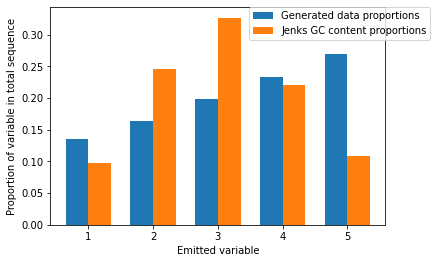

In [11]:
breaks = jenkspy.jenks_breaks(chromosome_gc_content, 5)
# Assign the data to each bin and make the interval closed
gc_content_fitted = np.digitize(chromosome_gc_content, breaks, right=True)
# The minimum value will be in the zeroth bin, because of the way that np.digitize works, so put it in the first bin
zero_bin_index = np.where(gc_content_fitted == 0)
gc_content_fitted[zero_bin_index] = 1

gc_content_proportions_jenks = np.array(
    [np.count_nonzero(gc_content_fitted == i) / len(gc_content_fitted) for i
     in range(1, (max(emitted_variables) + 1))])
# Create a figure and axis
fig, ax = plt.subplots()

# Set the width of the bars
bar_width = 0.35

# Create bar positions for side-by-side bars
bar_positions1 = np.arange(len(generated_data_proportions))
bar_positions2 = bar_positions1 + bar_width

# Plot the side-by-side bars
ax.bar(bar_positions1, generated_data_proportions, width=bar_width, label='Generated data proportions')
ax.bar(bar_positions2, gc_content_proportions_jenks, width=bar_width, label='Jenks GC content proportions')

# Add labels and legend
ax.set_xlabel('Emitted variable')
ax.set_ylabel('Proportion of variable in total sequence')
ax.set_xticks(bar_positions1 + bar_width / 2)
ax.set_xticklabels([f'{i + 1}' for i in range(len(generated_data_proportions))])
ax.legend(loc="upper right", bbox_to_anchor=(1.15, 1.025))
# Show the plot
plt.show()

In [12]:
print("Log-likelihood of the data from the first binning scheme:",
      format(hmm.forward_algorithm(gc_content_fitted_first_binning_scheme.astype(int))[0], ".2f"))
print("Log-likelihood of the data from the Jenks binning scheme:",
      format(hmm.forward_algorithm(gc_content_fitted)[0], ".2f"))

Log-likelihood of the data from the first binning scheme: -11068.96
Log-likelihood of the data from the Jenks binning scheme: -11613.58


### The backward algorithm
To carry out the Baum-Welch algorithm, we also need to find the probability we observe the rest of the sequence, after time $t$, given the hidden state at time $t$. To do this, a similar approach to the forward algorithm is taken. This time, the scaled backward variable, $\hat{\beta}_{n}(i)$ is defined. It uses the same scale factors, $c_{n}$ as in the forward algorithm and works recursively. However, the backward algorithm moves backwards through the sequence, starting with the last observation.

### The Baum-Welch algorithm
The Baum-Welch algorithm tries to find the $\theta$ which maximises the likelihood of an observed sequence. It is recursive and requires some initial parameter set, $\theta_{0}$, as well as a threshold, $\Delta$. The algorithm runs the forward and backward algorithms (the forward-backward algorithm) to find all $\hat{\alpha}_{n}(i)$ and $\hat{\beta}_{n}(i)$. The value of $\ln{L}$ is also calculated using the forward algorithm. The Baum-Welch algorithm then updates the parameter set. The cycle then repeats. The cycle is terminated if at time $t$, $|\ln{L_{t}} - \ln{L_{t-1}}| < \Delta$.

#### Measuring the accuracy of the Baum-Welch algorithm
To measure the accuracy of the Baum-Welch algorithm, we can enter a generated emitted sequence from the example HMM. We can then check the percentage accuracy of each predicted parameter, by dividing the element-wise absolute difference between the predicted and actual parameter matrices by the sum of the actual matrix for each parameter. This gives an idea of the mean error of proababilities associates with each hidden state for each parameter.

At times, the Baum-Welch algorithm predicts, $\mu^{0}$ to be, $\begin{bmatrix} 
    0 & 1 \\ 
    \end{bmatrix}$ 
 or, the same but reversed. This results in an error of 100%, when compared to the example HMM and is caused by the fact only one observed sequence is used.

The percentage errors shown below are calculated with a generated sequence of length 7914, and with a $\Delta$ of 0.2. They are low, indicating strong results.

The plot below demonstrates the maximisation of $ln{L}$.

The $\theta$ found by the algorithm is also displayed below.

A reminder of $\theta$ for the example HMM:

$$\bf{B} =  
\begin{bmatrix}
    0.4 & 0.3 & 0.2 & 0.1 & 0.0 \\
    0.0 & 0.1 & 0.2 & 0.3  & 0.4 \\
\end{bmatrix}
$$

$$\bf{A} = 
\begin{bmatrix}
    0.8 & 0.2 \\
    0.1 & 0.9 \\
\end{bmatrix}
$$

$$\mu^{0} = \begin{bmatrix} 
    0.5 & 0.5 \\ 
    \end{bmatrix}$$

Initial distribution error: 100.00 %
Transition matrix error: 1.15 %
Emission matrix error: 3.06 %


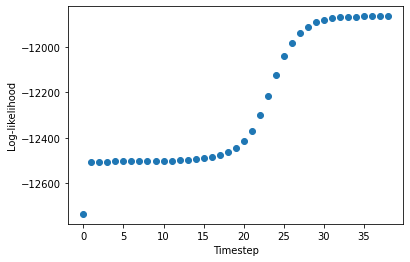

In [13]:
new_hmm = HiddenMarkovModel(hidden_states, emission_states)

initial_distribution_guess = np.array([0.5, 0.5])

transition_matrix_guess = np.array([[0.5, 0.5], [0.5, 0.5]])
emission_matrix_guess = np.array([[0.2, 0.3, 0.2, 0.1, 0.2], [0.2, 0.1, 0.2, 0.3, 0.2]])

new_hmm.set_transition_matrix(transition_matrix_guess)
new_hmm.set_emission_matrix(emission_matrix_guess)
new_hmm.set_initial_distribution(initial_distribution_guess)

# We don't want the difference to be too big, or it becomes an overfit
#likelihood_history_bw = new_hmm.baum_welch(gc_content_copy, 0.01)
likelihood_history_bw = new_hmm.baum_welch(np.array(obs_seq), 0.2)

plt.scatter(range(len(likelihood_history_bw)), likelihood_history_bw)
plt.xlabel("Timestep")
plt.ylabel("Log-likelihood")
plt.show()

## Find the differences between the actual parameters and the predicted ones
initial_distribution_prediction_accuracy = 100 * np.sum(abs(new_hmm.initial_distribution - initial_distribution)) / (
    np.sum(initial_distribution))
transition_matrix_prediction_accurancy = 100 * np.sum(abs(new_hmm.transition_matrix - transition_matrix)) / (
    np.sum(transition_matrix))
emission_matrix_prediction_accurancy = 100 * np.sum(abs(new_hmm.emission_matrix - emission_matrix)) / (
    np.sum(emission_matrix))

print("Initial distribution error:", format(initial_distribution_prediction_accuracy, ".2f"), "%")
print("Transition matrix error:", format(transition_matrix_prediction_accurancy, ".2f"), "%")
print("Emission matrix error:", format(emission_matrix_prediction_accurancy, ".2f"), "%")

In [14]:
print("Initial distribution:", new_hmm.initial_distribution)
print("Transition matrix:")
print(new_hmm.transition_matrix)
print("Emission matrix:")
print(new_hmm.emission_matrix)

Initial distribution: [2.48539004e-29 1.00000000e+00]
Transition matrix:
[[0.80899226 0.19100774]
 [0.10249079 0.89750921]]
Emission matrix:
[[0.38537646 0.30313391 0.20441715 0.10017718 0.00689529]
 [0.00043722 0.08882856 0.19518379 0.30489039 0.41066003]]


#### Multiple observations
To show the update of the initial distribution, an algorithm to run the Baum-Welch algorithm for multiple sequences was employed. The algorithm runs largely in the same way as the Baum-Welch algorithm for a single sequence. The same steps are run for each sequence. However, now one complete run through all sequences constitutes one iteration of the algorithm. 

The parameter updates are now influenced by all sequences, and the algorithm is terminated when the change in average log-likelihood, $\bar{\ln_{L}}$ is lower than $\Delta$. The $\bar{\ln_{L}}$ is the log-likelihood cumulative sum for one iteration divided by the total length of all sequences, and not of individual sequences.

To demonstrate this working, we will generate four sequences, using the example HMM each of length $115$. We will then train a new HMM on them. This results in the new HMM ending the algorithm with a similar $\theta$ as the example HMM. 

The algorithm finds the parameter set to a reasonable level of accuracy. A plot of the summed average likelihood history is shown below, as well as the errors on $\theta$, with errors calculated in the same way as above.

Initial distribution error: 7.97 %
Transition matrix error: 7.18 %
Emission matrix error: 14.72 %
Initial distribution: [0.53986849 0.46013151]
Transition matrix:
[[0.82558282 0.17441718]
 [0.14622501 0.85377499]]
Emission matrix:
[[3.55522784e-01 3.40735391e-01 1.44374593e-01 1.59367233e-01
  1.27150089e-35]
 [8.24750371e-26 8.61869077e-02 2.47071588e-01 2.79054533e-01
  3.87686971e-01]]


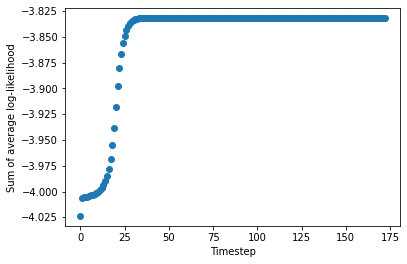

In [51]:
new_hmm_multiple_seq = HiddenMarkovModel(hidden_states, emission_states)

new_hmm_multiple_seq.set_transition_matrix(transition_matrix_guess)
new_hmm_multiple_seq.set_emission_matrix(emission_matrix_guess)
new_hmm_multiple_seq.set_initial_distribution(initial_distribution_guess)

obs_seq_for_multiple_1 = hmm.generate_sequence(115)[0]
obs_seq_for_multiple_2 = hmm.generate_sequence(115)[0]
obs_seq_for_multiple_3 = hmm.generate_sequence(115)[0]
obs_seq_for_multiple_4 = hmm.generate_sequence(115)[0]

multiple_seqs = np.vstack(
    [obs_seq_for_multiple_1, obs_seq_for_multiple_2, obs_seq_for_multiple_3, obs_seq_for_multiple_4])

multiple_seq_likelihood_history = new_hmm_multiple_seq.baum_welch_multiple_sequences(multiple_seqs, 0.00002)

sum_of_average_likelihoods_for_each_iteration = np.array(multiple_seq_likelihood_history).reshape(
    int(len(multiple_seq_likelihood_history) / 4), 4).sum(axis=1)

plt.scatter(range(len(sum_of_average_likelihoods_for_each_iteration)), sum_of_average_likelihoods_for_each_iteration)
plt.xlabel("Timestep")
plt.ylabel("Sum of average log-likelihood")
plt.show()

## Find the differences between the actual parameters and the predicted ones
initial_distribution_prediction_accuracy_multiple_seq = 100 * np.sum(
    abs(new_hmm_multiple_seq.initial_distribution - initial_distribution)) / (np.sum(initial_distribution))
transition_matrix_prediction_accurancy_multiple_seq = 100 * np.sum(
    abs(new_hmm_multiple_seq.transition_matrix - transition_matrix)) / (np.sum(transition_matrix))
emission_matrix_prediction_accurancy_multiple_seq = 100 * np.sum(
    abs(new_hmm_multiple_seq.emission_matrix - emission_matrix)) / (np.sum(emission_matrix))

print("Initial distribution error:", format(initial_distribution_prediction_accuracy_multiple_seq, ".2f"), "%")
print("Transition matrix error:", format(transition_matrix_prediction_accurancy_multiple_seq, ".2f"), "%")
print("Emission matrix error:", format(emission_matrix_prediction_accurancy_multiple_seq, ".2f"), "%")

print("Initial distribution:", new_hmm_multiple_seq.initial_distribution)
print("Transition matrix:")
print(new_hmm_multiple_seq.transition_matrix)
print("Emission matrix:")
print(new_hmm_multiple_seq.emission_matrix)

## The Viterbi algorithm
The Viterbi algorithm works finds the most likely sequence of hidden states for an observed sequence. At each time step, $n$, for a given hidden state, $i$, the Viterbi variable, $\phi_{n}(i_{n})$ is calculated. This is the maximum log probability of the hidden state and observed sequences at the $n^{th}$ step. The hidden state that does this is stored as a back pointer at the *next* time step in $\psi_{n}(i_{n})$.

Once the observed sequence has been iterated through (after $N$ steps), we find the state which corresponds to the highest probability of $\phi_{N}$. We then use $\psi$ to identify the most likely state at each previous time step, and so on until we reach the $0^{th}$ time step. This sequence of hidden states is the most likely sequence of hidden states.

### Measuring the accuracy of the Viterbi algorithm
To do this, we will generate a sequence of observed and emitted states from the example HMM. We will then pass the generated observed sequence into the Viterbi algorithm. The number of correct matches between the hidden state path from the Viterbi algorithm and the generated hidden states as a proportion of the sequence length. The algorithm shows a high accuracy (tested on a sequence of length 7914), suggesting it will offer a good prediction of the hidden states in the yeast chromosome.

In [16]:
predicted_hidden_state_seq = new_hmm.viterbi(np.array(obs_seq))
length_of_seq = len(obs_seq)

# We know they are going to be the same length, so use
number_of_correct_predictions = np.count_nonzero(
    np.array(obs_seq_with_hidden_states[1]).astype(int) == predicted_hidden_state_seq)

print("Accuracy of the Viterbi algorithm:", format((number_of_correct_predictions / length_of_seq) * 100, ".2f"), "%")

Accuracy of the Viterbi algorithm: 91.21 %


### Running the Viterbi algorithm with GC content data
An HMM with an appropriate parameter set is required to run the Viterbi algorithm on the GC data. To find this parameter set, the Baum-Welch algorithm is run.

The plot below shows the Baum-Welch algorithm maximising the likelihood for the GC content, which is binned as described above.

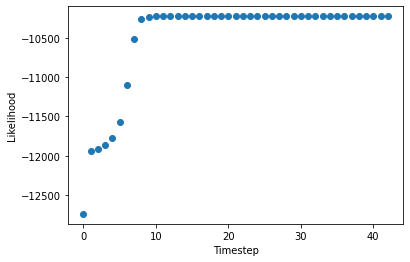

In [17]:
gc_hmm = HiddenMarkovModel(hidden_states, emission_states)

gc_hmm.set_transition_matrix(transition_matrix_guess)
gc_hmm.set_emission_matrix(emission_matrix_guess)
gc_hmm.set_initial_distribution(initial_distribution_guess)

# We don't want the difference to be too big, or it becomes an overfit
gc_likelihood_history_bw = gc_hmm.baum_welch(gc_content_fitted, 0.01)

plt.scatter(range(len(gc_likelihood_history_bw)), gc_likelihood_history_bw)
plt.xlabel("Timestep")
plt.ylabel("Likelihood")
plt.show()

Once an optimal, $\theta$ is obtained, the Viterbi algorithm is run.

The plot below, displaying the hidden state seqeunce output from the Viterbi algorithm shows that high and low GC contents are associated with hidden states $1$ and $0$ respectively.

In a biological context, a high GC content is more likely to be associated with a protein coding region. Therefore, hidden state $1$ should align with protein coding regions on the chromosome.

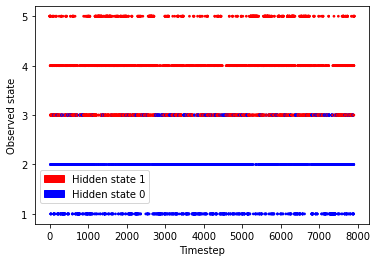

In [18]:
gc_predicted_hidden_state_seq = np.array(gc_hmm.viterbi(gc_content_fitted))

# Make a plot of the emitted states as well

# Choose the colour of the points based on the hidden state
col = np.where(gc_predicted_hidden_state_seq == 0, 'b', 'r')

plt.scatter(np.arange(len(gc_predicted_hidden_state_seq)), gc_content_fitted, c=col, s=7.5, linewidth=0)
plt.yticks(np.arange(min(gc_content_fitted), max(gc_content_fitted) + 1, 1.0))
red_patch = mpatches.Patch(color='red', label='Hidden state 1')
blue_patch = mpatches.Patch(color='blue', label='Hidden state 0')
plt.legend(handles=[red_patch, blue_patch], loc="lower left", bbox_to_anchor=(0, 0.0725))
plt.xlabel("Timestep")
plt.ylabel("Observed state")
plt.rcParams['figure.figsize'] = (8, 5)
plt.show()

In [19]:
# Reset figure size to default for later cells
plt.rcParams['figure.figsize'] = (6.0, 4.0)

Given that we are iterating through GC content values which were created in a specifc way ($100bp$ windows with $40bp$ shifts), we can relate back the position of each GC content value to a region on the chromosome. Since each hidden state relates to one GC content value, we can also relate each hidden state to a region on the chromosome.

Specifically, we want to investigate the location of hidden states, $1$ on the chromosome. They should match identified protein coding regions on the chromosome.

In [20]:
# To get the location of hidden states, get indices of hidden state 1 in gc_content and then 
# multiply those sizes by window size
# and add the window size to the end of it to get the whole length

indicies_of_hidden_state_1 = np.array(np.where(gc_predicted_hidden_state_seq == 1)).flatten()

start_of_protein_coding_region = indicies_of_hidden_state_1 * DEFINED_WINDOW_SHIFT_SIZE

end_of_protein_coding_region = start_of_protein_coding_region + np.full(len(indicies_of_hidden_state_1),
                                                                        DEFINED_WINDOW_SIZE)

protein_regions = np.vstack([start_of_protein_coding_region, end_of_protein_coding_region]).flatten('F')

#### A qualitative comparison with Ensembl

If we create a histogram of these locations of hidden state $1$, we should theoretically be able to recreate the below histogram from Ensembl.
<!-- <figure>
    <center> <img src="wholeChromosome.png"  alt='missing' width="800"  ><center/>
<figure/> -->

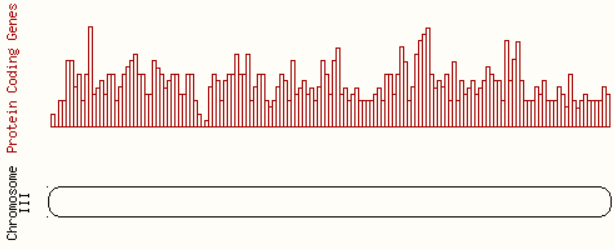

In [47]:
from IPython.display import Image
Image(filename='wholeChromosome.png')

To compare histograms, we will identify regions of the histogram which should match. For example, the region around $200000bp$ is slightly higher than the surrounding region. The label in brown to the right shows the highlighted region boundaries in bp.

<!-- <figure>
    <center> <img src="Around200000.png"  alt='missing' height="250"  ><center>
<figure/> -->

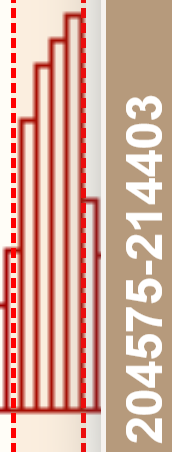

In [45]:
Image(filename='Around200000.png')

A 'gap' was identified around $170000bp$.
<!-- <figure>
    <center> <img src="Gap170000.png"  alt='missing' height="250"  ><center>
<figure/> -->

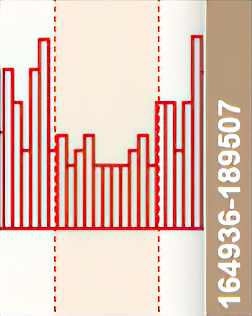

In [46]:
Image(filename='Gap170000.png')

The density histogram below represents the frequceny of location associated with hidden state $1$. It can be seen there is some association with the histograms above.

For example, the region associated with a gap is lower than the surrounding areas.

Likewise, the region around $20000bp$ is higher than the surrounding region.

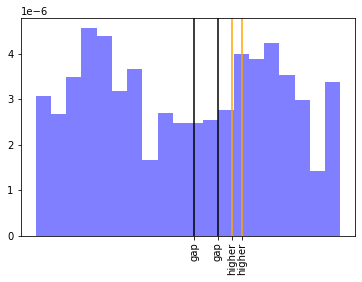

In [21]:
plt.hist(protein_regions, bins='auto', ls='dashed', edgecolor='None', alpha=0.5, color='b', density=True)
plt.xticks([164936, 189507, 204575, 214403], ["gap", "gap", "higher", "higher"])
plt.xticks(rotation=90)
plt.axvline(x=164396, color='black')
plt.axvline(x=189507, color='black')
plt.axvline(x=204575, color='orange')
plt.axvline(x=214403, color='orange')
plt.show()

### An alternative emission space
Despite the agreement between the histogram from Ensembl and produced with Viterbi, the model could be improved upon. Currently, the emission space only represents $5$ values.

However, there are $101$ possible values of GC content (assuming $100bp$ windows). Therefore, an emission space with only $5$ variables may be too coarsely grained.

Since the GC content is never $0$ and the lowest value GC content takes is $0.11$, the number of emitted variables was chosen to be $90$.

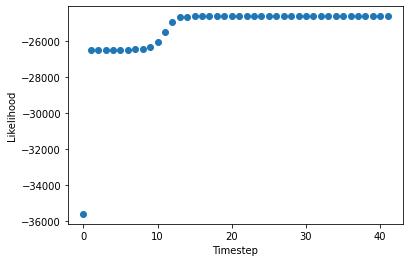

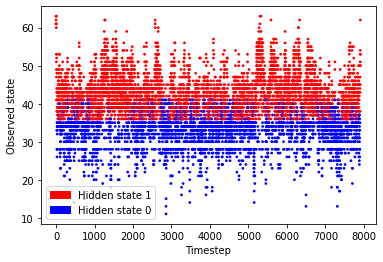

In [22]:
number_of_emitted_variables_for_improved_hmm = 90

# Generate equally spaced values, from 0.1, so there is no divide by zero error
equally_spaced_values = np.linspace(0.1, 1, number_of_emitted_variables_for_improved_hmm)

# Ensure the sum of the array is 1
emission_matrix_row_guess_for_improved_gc_hmm = equally_spaced_values / np.sum(equally_spaced_values)
emission_matrix_guess_for_improved_gc_hmm = np.vstack(
    (np.flip(emission_matrix_row_guess_for_improved_gc_hmm), emission_matrix_row_guess_for_improved_gc_hmm))

improved_gc_hmm = HiddenMarkovModel(hidden_states, range(1, number_of_emitted_variables_for_improved_hmm))

improved_gc_hmm.set_transition_matrix(transition_matrix_guess)
improved_gc_hmm.set_emission_matrix(emission_matrix_guess_for_improved_gc_hmm)
improved_gc_hmm.set_initial_distribution(initial_distribution_guess)

gc_content_rescaled = (chromosome_gc_content * 100).astype(int)

# We don't want the threshold to be too big, or it becomes an overfit
gc_likelihood_history_bw_improved = improved_gc_hmm.baum_welch(gc_content_rescaled, 0.01)
plt.scatter(range(len(gc_likelihood_history_bw_improved)), gc_likelihood_history_bw_improved)
plt.xlabel("Timestep")
plt.ylabel("Likelihood")
plt.show()

gc_predicted_hidden_state_seq_improved = np.array(improved_gc_hmm.viterbi(gc_content_rescaled))

# Make a plot of the emitted states as well

# Choose the colour of the points based on the hidden state
col = np.where(gc_predicted_hidden_state_seq == 0, 'b', 'r')

plt.scatter(np.arange(len(gc_predicted_hidden_state_seq_improved)), gc_content_rescaled, c=col, s=7.5, linewidth=0)
red_patch = mpatches.Patch(color='red', label='Hidden state 1')
blue_patch = mpatches.Patch(color='blue', label='Hidden state 0')
# Adjust the legend on y axis to be between 1 and 2 so that it is not potentially hiding some data points
plt.legend(handles=[red_patch, blue_patch])
plt.xlabel("Timestep")
plt.ylabel("Observed state")
plt.show()

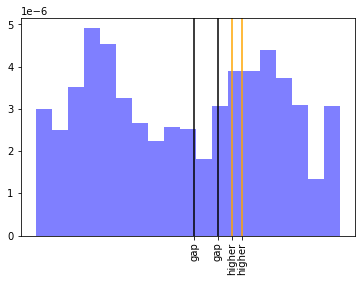

In [23]:
indicies_of_hidden_state_1_improved = np.array(np.where(gc_predicted_hidden_state_seq_improved == 1)).flatten()

start_of_protein_coding_region_improved = indicies_of_hidden_state_1_improved * DEFINED_WINDOW_SHIFT_SIZE

end_of_protein_coding_region_improved = start_of_protein_coding_region_improved + np.full(
    len(indicies_of_hidden_state_1_improved), DEFINED_WINDOW_SIZE)

protein_regions_improved = np.vstack(
    [start_of_protein_coding_region_improved, end_of_protein_coding_region_improved]).flatten('F')

plt.hist(protein_regions_improved, bins='auto', ls='dashed', edgecolor='None', alpha=0.5, color='b', density=True)
plt.xticks([164936, 189507, 204575, 214403], ["gap", "gap", "higher", "higher"])
plt.xticks(rotation=90)
plt.axvline(x=164396, color='black')
plt.axvline(x=189507, color='black')
plt.axvline(x=204575, color='orange')
plt.axvline(x=214403, color='orange')
plt.show()

#### Comparison of parameters between HMMs
The initial distributions of the orignal HMM and larger emission space (improved) HMM are the same, as only one sequence was used to estimate $\theta$ for each HMM.

There are also still only two hidden states, and so the transition matrices also look similar.

In [24]:
print("Initial distribution of original HMM for GC content:", gc_hmm.initial_distribution)
print("Initial distribution of improved HMM for GC content:", improved_gc_hmm.initial_distribution)

print("Transition matrix of original HMM for GC content:")
print(gc_hmm.transition_matrix)
print("Transition matrix of improved HMM for GC content:")
print(improved_gc_hmm.transition_matrix)

Initial distribution of original HMM for GC content: [0. 1.]
Initial distribution of improved HMM for GC content: [0. 1.]
Transition matrix of original HMM for GC content:
[[0.88819239 0.11180761]
 [0.11541426 0.88458574]]
Transition matrix of improved HMM for GC content:
[[0.89793004 0.10206996]
 [0.10847186 0.89152814]]


However, in the improved HMM the emission matrix is much larger, reflecting the larger emission space.

In [44]:
print("Emission matrix shape of original HMM for GC content:")
print(gc_hmm.emission_matrix.shape[0], "X", gc_hmm.emission_matrix.shape[1])
print("Emission matrix shape of improved HMM for GC content:")
print(improved_gc_hmm.emission_matrix.shape[0], "X", improved_gc_hmm.emission_matrix.shape[1])

Emission matrix shape of original HMM for GC content:
2 X 5
Emission matrix shape of improved HMM for GC content:
2 X 90


Unfortunately, without the quantitative data from Ensembl for the histogram plot, no statistical measure of the goodness of fit for each model can be applied. However, the ratio of the likelihoods from each model can be compared, using a likelihood ratio. 

Since the likelihood ratio is distributed as a Chi-squared, then a p-value can be calculated.

If the null hypothesis, $H_{0}$ is that both HMMs fit their GC content data equally well, and the alternative hypothesis, $H_{1}$ is that the improved HMM fits the data better, with a significance level of $5\%$, $H_{0}$ remains.

Therefore, the improved HMM is not adopted.

In [26]:
lr = -2 * (gc_likelihood_history_bw[-1] / len(gc_content_fitted) - gc_likelihood_history_bw_improved[-1] / len(
    gc_content_rescaled))
print("likelihood ratio:", format(lr, ".2f"))
print("p-value:", chi2.sf(lr, 1))

likelihood ratio: -3.64
p-value: 1.0
